# Hello World! NeMo-Run style!

Let's start with a simple notebook that demonstrates how to use the NeMo Run to configure and launch your Python functions. In this example, we will take simple addition functions that look like

```python
def add(a: int, b: int) -> int:
    print(f"Adding {a} to {b} returns {a + b}")
    return a + b
```

and use NeMo Run to configure and launch it. This basic notebook should demonstrate a lot of the building blocks of our NeMo Run.

As described in the introduction, NeMo Run is a tool that allows you to:
1. Configure your functions or scripts in a pythonic way
2. Launch them on any supported remote cluster directly from your local workstation
3. Manage them using Experiments. 

Let's get into it.


In [1]:
# SPDX-FileCopyrightText: Copyright (c) 2024 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: Apache-2.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Set up and imports
import logging

import nemo_run as run
from nemo_run.core.execution import LocalExecutor
from simple.add import add

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(message)s")


### 1. Configuration

The first step in using NeMo Run is to configure your python function. As mentioned above, we're trying to configure the `add` function. Configuration is similar to python's native [functools.partial](https://docs.python.org/3/library/functools.html#functools.partial). In fact, for most functions you can replace `functools.partial` with `run.Partial` and it should still work. Configuration just ties your function and your arguments together to create an `run.Partial` object which can be shipped around to executed at a later time. This is done by building the `run.Partial` object which will recursively build any configured objects and then return a [`functools.partial` object](https://docs.python.org/3/library/functools.html#partial-objects).

This brings us to our first building blocks of NeMo Run - `Partial` and `Config`. These are buildables that allow you to configure functions, arguments and objects in a pythonic way. Under the hood, we use [fiddle](https://fiddle.readthedocs.io/en/latest/) to manage the configuration. In fact, our `Partial` and `Config` subclass `fiddle.Partial` and `fiddle.Config` respectively, with some addons that help with the UX and programmability of your configuration. We take some inspiration from [Praxis](https://github.com/google/praxis/blob/main/praxis/pax_fiddle.py#L72) but also have custom addons that we believe should improve the user experience.

We already discussed `run.Partial`. `run.Config` is similar in the sense that it takes a `fn` or `class` as the first argument and the `fn` or `class` `*args` and `**kwargs` as the subsequent arguments. However, on building `run.Config` it actually calls the underlying `fn` or in case of a `class` its `__init__` method with the arguments tied into the `Config`. So for example

```python
import fiddle as fdl
import nemo_run as run
def hello_world(msg: str):
    print(f"Hello World! {msg}")

cfg = run.Config(hello_world, msg="How are you?")
partial = run.Partial(hello_world, msg="How are you?")

fn = fdl.build(partial)
fn()
#>>> Hello World! How are you?

built_cfg = fdl.build(cfg)
#>>> Hello World! How are you?

print(built_cfg is None)
#>>> True
```

The `Partial` and `Config` classes also come with utilities that provide a visual representation of the object (if you have `graphviz` installed). Try running the cell below to configure the `add` function and visualize the configured `Partial`.

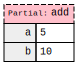

In [2]:
fn = run.Partial(add, a=5, b=10)
fn

The configured function is now ready for execution. But before we go into execution, let's look at configuring complex functions that take in non-primitive types. Along with it, we will also look at another utility that NeMo Run provides - `run.autoconvert`. `run.autoconvert` is a decorator that allows you to automatically convert functions returning regular Python objects to functions that return a `run.Config` of the underlying object. To demonstrate this, let's consider an `add_object` function that looks like 

```python
@dataclass
class SomeObject:
    value_1: int
    value_2: int
    value_3: int


def add_object(obj_1: SomeObject, obj_2: SomeObject) -> SomeObject:
    result = SomeObject(
        value_1=obj_1.value_1 + obj_2.value_1,
        value_2=obj_1.value_2 + obj_2.value_2,
        value_3=obj_1.value_3 + obj_2.value_3,
    )
    print(f"{result = }")

    return result
```

To configure this function, you can use `run.Partial`. Note however that you will need to ensure that the arguments to the function are `run.Config` or `run.Partial` instances as well. This is necessary for serialization and remote execution, but more on that later. For now, a basic configuration for `add_object` looks like

```python
run.Partial(
    add_object,
    obj_1=run.Config(SomeObject, value_1=10, value_2=20, value_3=30),
    obj_2=run.Config(SomeObject, value_1=10, value_2=20, value_3=30),
)
```

Now, let's say you have a regular python function that returns `SomeObject` and you want to use it as one of the arguments to `add_object`. You can decorate it using `run.autoconvert` as follows:
```python
@run.autoconvert
def commonly_used_object() -> SomeObject:
    return SomeObject(
        value_1=5,
        value_2=10,
        value_3=15,
    )
```

The `run.autoconvert` decorator uses fiddle's autoconfig and parses the AST so that you get the following:

```python
commonly_used_object() == run.Config(SomeObject, value_1=5, value_2=10, value_3=15)
```


You can then use the decorated function as follows:
```python
run.Partial(
    add_object,
    obj_1=run.Config(SomeObject, value_1=10, value_2=20, value_3=30),
    obj_2=commonly_used_object(),
)
```

Additionally, you can also use args in the function. Note however that `run.autoconvert` currently doesn't support control flow and may be unreliable for complex code. In that case, you can define a function to return the `run.Config` directly, as follows:

```python
def commonly_used_config() -> run.Config[SomeObject]:
    config = run.Config(
        SomeObject,
        value_1=5,
        value_2=10,
        value_3=15,
    )

    for i in range(10):
        config.value_1 *= i
        config.value_2 += i
        config.value_3 -= i

    return config
```

> 📝 `autoconvert` returns a `run.Config` of the underlying object by default whereas `@autoconvert(partial=True)` returns a `run.Partial` of the underlying object

One additional thing is that the arguments of a `run.Partial` or `run.Config` can be mutated via dot access, as shown below:
```python
fn.obj_1.value_1 = 100
fn.obj_2.value_2 *= 2
...
```

As you can see, our tool is designed to provide a lot of flexibility. Run the below cells to experiment with these APIs. Run the cells below to learn about the different ways to configure your task/function.

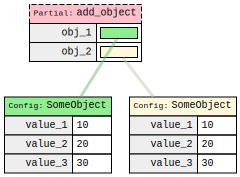

In [3]:
from simple.add import add_object, commonly_used_object, commonly_used_object_2, SomeObject

fn = run.Partial(
    add_object,
    obj_1=run.Config(SomeObject, value_1=10, value_2=20, value_3=30),
    obj_2=run.Config(SomeObject, value_1=10, value_2=20, value_3=30),
)
fn

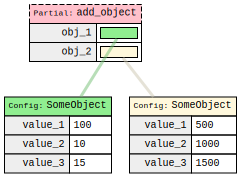

In [4]:
fn = run.Partial(add_object, obj_1=commonly_used_object(), obj_2=commonly_used_object_2())
fn.obj_1.value_1 = 100
fn

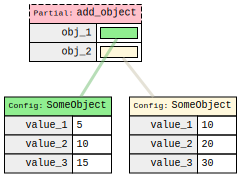

In [5]:
fn = run.Partial(
    add_object,
    obj_1=commonly_used_object(),
    obj_2=run.Config(SomeObject, value_1=10, value_2=20, value_3=30)
)
fn

### 2. Execution

The above section conclues the core features of NeMo Run's configuration side. Now let's move on to execution. The core building block to execute a single function is `run.run`.

The easiest way to execute a configured function is to execute it directly, just like you would execute a normal python function. You can do this using the `direct` option in `run.run` as shown below:
```python
# You can also do a dryrun to see what's getting executed where.
run.run(fn, direct=True, dryrun=True)
run.run(fn, direct=True)
```

> 📝 As of now, the `run` function doesn't recreate the return value, so it is the user's responsibility to manage the artifacts from the function. For example, if you are launching a function to train an ML model, make sure you configure a job directory which you can access and later go and inspect. We are working on improving the management capabilities of a run and open to feedback, so please reach out to us if you have any ideas.

Try it out in the cell below.

In [6]:
# You can also do a dryrun to see what's getting executed where.
run.run(fn, direct=True, dryrun=True)
run.run(fn, direct=True)

Dry run for task simple.add:add_object

Resolved Arguments

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Argument Name        ┃ Resolved Value                                               ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ obj_1                │ SomeObject(value_1=5, value_2=10, value_3=15)                │
│ obj_2                │ SomeObject(value_1=10, value_2=20, value_3=30)               │
└──────────────────────┴──────────────────────────────────────────────────────────────┘

result = SomeObject(value_1=15, value_2=30, value_3=45)


Direct run is not that interesting, since you wouldn't have to use `run` if you were only running the function directly. On top of direct runs, we support a couple of executors out of the box:
1. Local executor: This will run the function locally but in a separate process. Useful when you are using components like `torchrun` to launch your job/run.
2. Slurm executor: This will run the function on a remote Slurm cluster. Currently, only Slurm clusters that have [Pyxis](https://github.com/NVIDIA/pyxis) are supported, but we plan to add support for all kinds of slurm clusters. Reach out to us if you have a specific request.
3. Skypilot executor: This will run the function on any cloud supported via [Skypilot](https://skypilot.readthedocs.io/en/latest/).

To learn more about executors, go to the execution guide linked in [README](../../README.md).

> 📝 Currently, we do not pickle the function but rely on python module references for serializing the configured function. This means that executing a function defined in this notebook (or in the same script calling `run.run`) will probably not work. During packaging, we currently use `git archive` for our remote slurm executor and you can specify a subpath which will be set as the working directory for the execution. So for example, to execute `add_object` function, you will provide a subpath of `examples/hello-world` assuming `examples` is at the root of the repository. This will ensure that during remote execution, imports of the style `from simple.add import add_object` work properly. We are looking to improve this user experience and open to suggestions, so please reach out to us if you have any ideas. We will also look to add `cloudpickle` support for arbitrarily defined functions.


Under the hood, we are using [TorchX](https://pytorch.org/torchx/latest/) to manage the execution. But this is fairly abstracted away from the user and we can potentially support more standlone executor libraries or add custom schedulers for TorchX in the future.

Let's see the local executor in action. The local executor is the simplest executor we have, and can be intialized without any arguments. Once we have an instance of `run.LocalExecutor`, we can pass it to `run.run` to execute the same configured function on the local executor, which will run the function in a separate process. This is the ease of use provided by NeMo Run. You can configure a function once, and execute it on any supported remote cluster seamlessly. Later, we will also explore `run.Experiment` which allows you to combine and manage multiple runs; giving additional flexibility to the user.

Execute the cells below to run your function on the local executor.

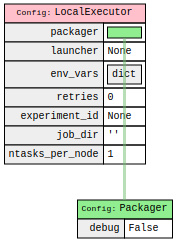

In [9]:
executor = run.LocalExecutor()
executor

In [10]:
run.run(fn, executor)

─────────────── Entering Experiment simple.add.add_object with id: simple.add.add_object_1723699155 ───────────────

[22:19:15] Launching task simple.add.add_object for experiment simple.add.add_object              ]8;id=730699;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=838648;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py#577\577]8;;\

Log directory is: /home/hemild/.nemo_run/experiments/simple.add.add_object/simple.add.add_object_1723699155/simple.add.add_object
Launched app: local_persistent://nemo_run/simple.add.add_object-rmf4rzw4nw5v4
AppStatus:
    State: RUNNING
    Num Restarts: 0
    Roles: 
    Msg: <NONE>
    Structured Error Msg: <NONE>
    UI URL: file:///home/hemild/.nemo_run/experiments/simple.add.add_object/simple.add.add_object_1723699155/simple.add.add_object/nemo_run/simple.add.add_object-rmf4rzw4nw5v4
    


──────────────────────── Waiting for Experiment simple.add.add_object_1723699155 to finish ────────────────────────

Experiment Status for simple.add.add_object_1723699155

Task 0: simple.add.add_object
- Status: RUNNING
- Executor: LocalExecutor
- Job id: simple.add.add_object-rmf4rzw4nw5v4
- Local Directory: /home/hemild/.nemo_run/experiments/simple.add.add_object/simple.add.add_object_1723699155/simple.add.add_object

Waiting for the app to finish [log=True]...


simple.add.add_object/0 result = SomeObject(value_1=15, value_2=30, value_3=45)


Job finished: SUCCEEDED
AppStatus:
  msg: <NONE>
  num_restarts: 0
  roles: []
  state: SUCCEEDED (4)
  structured_error_msg: <NONE>
  ui_url: file:///home/hemild/.nemo_run/experiments/simple.add.add_object/simple.add.add_object_1723699155/simple.add.add_object/nemo_run/simple.add.add_object-rmf4rzw4nw5v4



                                                                                                                   
# The experiment was run with the following tasks: ['simple.add.add_object']                                       
# You can inspect and reconstruct this experiment at a later point in time using:                                  
experiment = run.Experiment.from_id("simple.add.add_object_1723699155")                                            
experiment.status() # Gets the overall status                                                                      
experiment.logs("simple.add.add_object") # Gets the log for the provided task                                      
experiment.cancel("simple.add.add_object") # Cancels the provided task if still running                            
                                                                                                                   

                                                                                                                   
# You can inspect this experiment at a later point in time using the CLI as well:                                  
nemorun experiment status simple.add.add_object_1723699155                                                         
nemorun experiment logs simple.add.add_object_1723699155 0                                                         
nemorun experiment cancel simple.add.add_object_1723699155 0                                                       
                                                                                                                   

If you notice the logs, it has mentions of Experiment. Each `run.run` internally creates an experiment with a single task to provide management capabilities for a run out of the box. We also make the `run.Experiment` API available publicly to create custom experiments and workflows. Check out our next tutorial in this series named [`hello_experiments.ipynb`](hello_experiments.ipynb) to learn more about experiments.

In the same way, you can execute your configured function on a remote Slurm Cluster or remote Skypilot Cluster as well. 

Below, we show an example of defining a `run.SlurmExecutor`. NeMo-Run also sets up an `ssh` tunnel automatically for you to connect to the slurm cluster and handle the packaging of the code so you never have to leave your local workstation. You can configure the Slurm executor as below:

```python
tunnel_cfg = run.Config(
    TunnelConfig,
    host=os.environ["SLURM_HOST"],
    user=os.environ["SLURM_USER"],
    job_dir=os.environ["SLURM_JOBDIR"],
)
packager = run.Config(
    GitArchivePackager,
    use_torchrun=False,
    subpath="examples/hello-world"
)

executor = run.Config(
    SlurmExecutorConfig,
    account=os.environ["SLURM_ACCT"],
    partition=os.environ["SLURM_PARTITION"],
    nodes=1,
    ntasks_per_node=1,
    tunnel=tunnel,
    container_image=os.environ["BASE_IMAGE"],
    time="00:30:00",
    packager=packager,
)
```

More details about configuring the executors can be found in the `API Reference` portion of our docs.